**L200921 Aisha Muhammad Nawaz**  
**BSCS 8A Midterm 2 Exam Solution**  
**MINING OF MASSIVE DATASETS**  
**SPRING 2024**   
**DUE: 9th April 2024 (Tuesday)**

In [ ]:
#Running on Colab
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-8-openjdk-amd64'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=c4eb8e2cca258a0a74e9f717535dbbc1a38a276d72613b15bce96c8053231278
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark
The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra fonts-nanum fonts-ipafont-gothic
  fonts-ipafont-mincho fonts-wqy-microhei fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 39.7 MB of archives.
After this operation, 144 MB of additional disk space will be used.
Selecting previously unselected package

In [ ]:
#  Importing Required Libraries
import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

# Create Spark session and ContextRun PySpark.
# create the session
conf = SparkConf().set("spark.ui.port","4050")
# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.appName("DataFrame").config('spark.ui.port', '4050').getOrCreate()
spark

Q1 [marks]:  
KMeans Algorithm is executed on a massive 2D dataset, and the result is saved in a file &quot;F1&quot;.  Your task is to input the huge result file F1 and write efficient SPARK code to compute the
Davies–Bouldin Index (DBI) for evaluating the clustering quality.  
The Davies–Bouldin index(DBI) measures the
average similarity between each cluster and its
most similar cluster,
here, similarity is defined based on the Euclidean
distance between cluster centroids.

Input File F1 format (2D point, cluster ID)  
(1,2), C1  
(5,5), C2  
(2,2), C1  
(11, 11), C3  
…  

Let&#39;s compute DB1 step by step using SPARK. You can use SPARK DataFrame or RDDs. Provide spark code for each part given below:   

a. Input File F1 in SPARK and compute the centroid of each cluster.  
b. Compute the average (avg) distance of points in each cluster to its centroid.  
c. Compute the similarity between each pair of clusters as follows:  
For example, Similarity(Cluster 1, Cluster 2) = (Euclidean distance between centroid 1 and 2) /
(maximum of (avg distances of points from centroids in C1, avg distances of points from
centroids in C2))
Note: Avg distances are computed in part(b).  
d. Compute the Davies–Bouldin Index(DBI) = Average of the pair-wise similarities between clusters
computed in part(c).  

[HINT] The Set of 2D points is huge(big data), but the number of clusters is very small compared to
that.

In [ ]:
import numpy as np
def getPointClusterPair(line):
  x,y,cluster=line.split(',')
  x=float(x.replace('(',''))
  y=float(y.replace(')',''))
  cluster=cluster.replace(' ','')
  return cluster,(x,y,1)

# a. Input File F1 in SPARK and compute the centroid of each cluster.
f1=sc.textFile('F1.txt').map(lambda line: getPointClusterPair(line)) #Cluster as Key and value is point and count of point
f1Sum=f1.reduceByKey(lambda x,y: (x[0]+y[0],x[1]+y[1],x[2]+y[2]))    #Summing up coordinates value in each cluster as well as the count of points
f1Centroid=f1Sum.mapValues(lambda x:(x[0]/x[2],x[1]/x[2]))           #Computing Avg by dividng sum of coordinates by count of coordinates in each cluster
f1Centroid.collect()

[('C1', (1.5, 2.0)), ('C2', (5.0, 5.0)), ('C3', (11.0, 11.0))]

In [ ]:
# b. Compute the average (avg) distance of points in each cluster to its centroid.
f1CentroidCollected=dict(f1Centroid.collect()) #Converting prev step ans to dictionary form
f1DistCentroid=f1.map(lambda x:(x[0],((x[1][0]-f1CentroidCollected[x[0]][0])**2+(x[1][1]-f1CentroidCollected[x[0]][1])**2,1))) #dist points in each cluster to its centroid.
f1DistCentroid2=f1DistCentroid.reduceByKey(lambda x,y: (x[0]+y[0],x[1]+y[1])) #Summing up dist and count of point in each cluster
f1DistCentroidFinal=f1DistCentroid2.mapValues(lambda x:(np.sqrt(x[0])/x[1]))   #Computing Avg by dividng euc dist by count of coordinates in each clus
f1DistCentroidFinal.collect()

[('C1', 0.3535533905932738), ('C2', 0.0), ('C3', 0.0)]

In [ ]:
# c. Compute the similarity between each pair of clusters as follows:
# Similarity(Cluster 1, Cluster 2) = (Euclidean distance between centroid 1 and 2) / (maximum of (avg distances of points from centroids in C1,
#  avg distances of points from centroids in C2)) Note: Avg distances are computed in part(b).
clusterDistAvg=dict(f1DistCentroidFinal.collect()) #Converting prev step ans to dictionary form
res={}
for cluster1,dist1 in clusterDistAvg.items():
  for cluster2,dist2 in clusterDistAvg.items():
    if(cluster1 != cluster2 and (cluster1+cluster2) not in res and (cluster2+cluster1) not in res): #To ensure no duplicate entries
      maxDist=dist1
      if(dist2>dist1):
        maxDist=dist2 #Finding max dist
      # Finding Euclidean Distance
      euclideanDistance=np.sqrt((f1CentroidCollected[cluster1][0]-f1CentroidCollected[cluster2][0])**2+(f1CentroidCollected[cluster1][1]-f1CentroidCollected[cluster2][1])**2)
      res[cluster1+cluster2]=euclideanDistance/maxDist if maxDist > 0 else 0 #Finally saving similarity in res dictionary for the pair

print(res)

{'C1C2': 13.038404810405297, 'C1C3': 37.013511046643494, 'C2C3': 0}


In [ ]:
# d. Compute the Davies–Bouldin Index(DBI) = Average of the pair-wise similarities between clusters computed in part(c).
sumSim=0
count=0
for key,value in res.items():
  sumSim=sumSim+value #Summing up all the similarites
  count=count+1       #Counting all the pairs
DBI=sumSim/count if count>0 else 0
print('Davies–Bouldin Index(DBI) = ',DBI)

Davies–Bouldin Index(DBI) =  16.683971952349598


Q2 [marks]: We applied user-based collaborative filtering on YouTube&#39;s video dataset. Each user gives a
thumb-up or thumb-down sign on each video, which is changed to 1 and 0 in data.  
        V1 V2 V3 V4  
UserA 1 0 1  1  
UserB 0 1 1  1  

a) Find the similarity between User 1 and User 2 using Jaccard, Cosine, and Pearson Correlation.  
b) Which is the best measure for finding user similarity for the given dataset? Briefly explain your
answer.  
c) In the case of Jaccard similarity, what should be done with missing values?

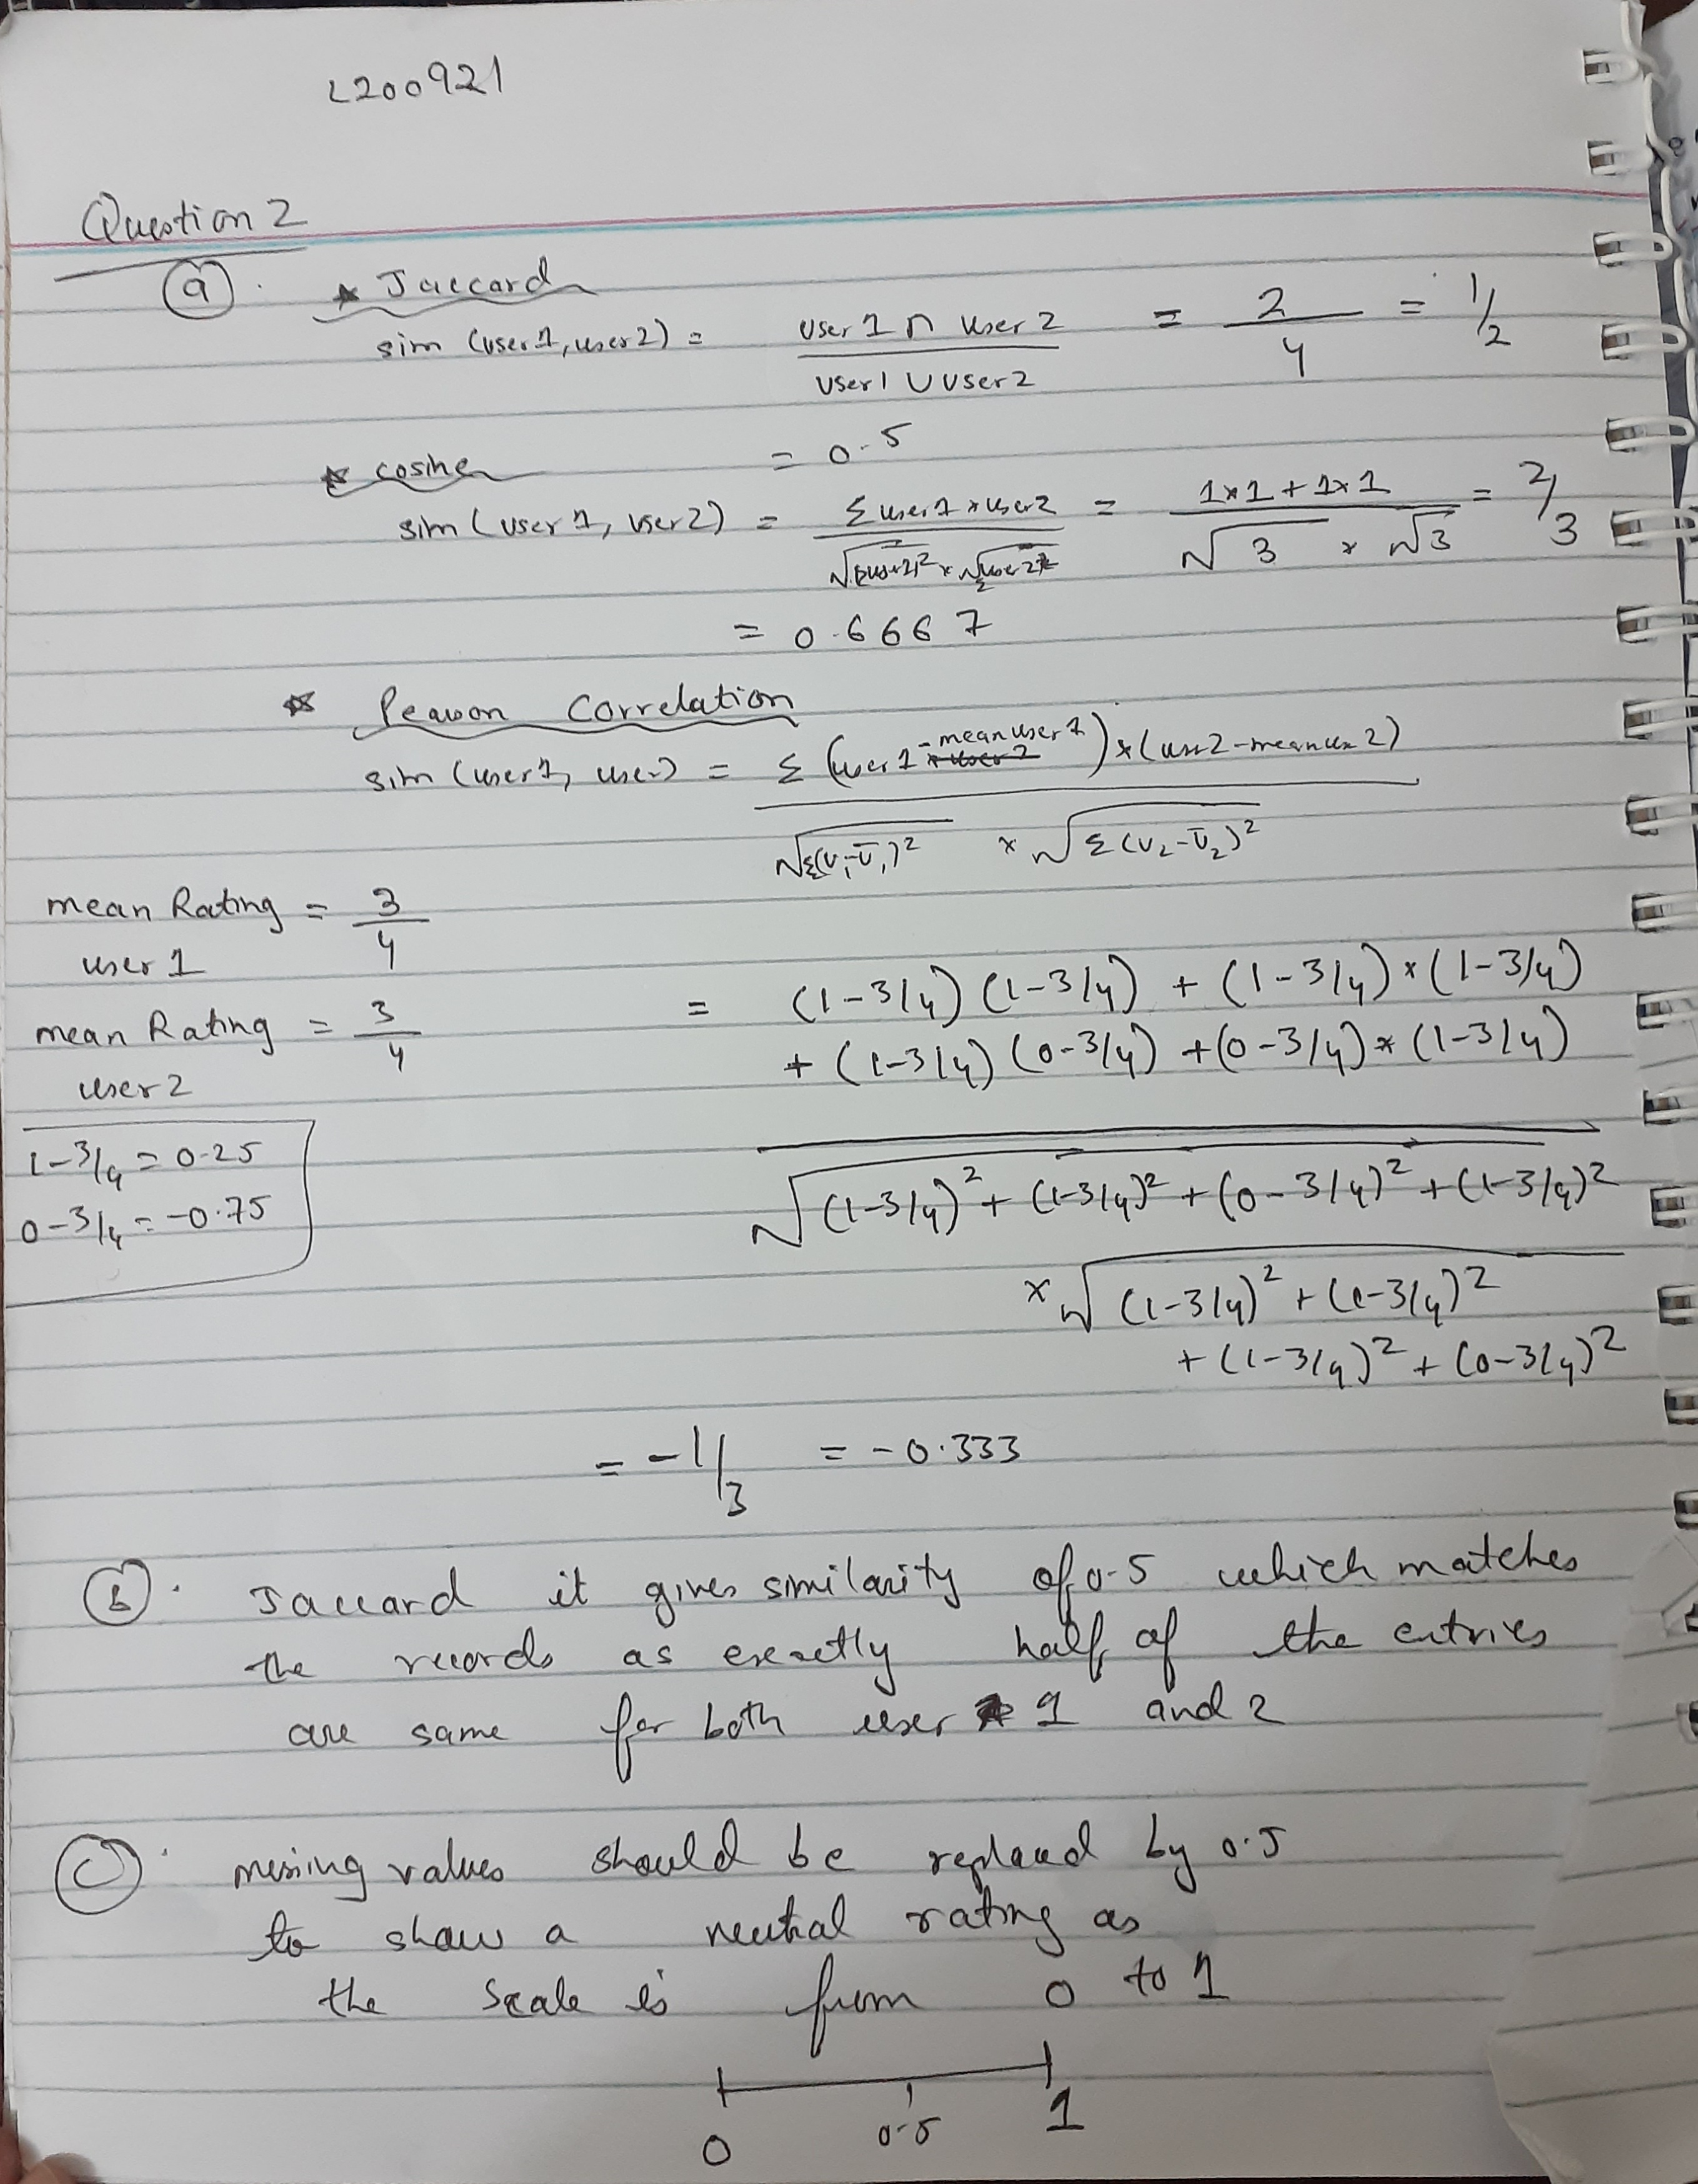